# Tutorial básico - Histogram of Oriented Gradients (HOG)

## Imports

In [1]:
# Interfaz para hacer gráficos y visualizaciones
import matplotlib.pyplot as plt

# Computación científica
import numpy as np

# data: conjunto de datos de muestra y funciones de carga
# color: convertir imágenes entre espacios de color
# feature: funciones para identificar y extraer características de imágenes
from skimage import data, color, feature

# Cambiar el tamaño de una imagen
from skimage.transform import resize, rescale

## Histogram of oriented gradients (HOG)

### Ejemplo de uso

In [2]:
# Imagen de ejemplo
data.chelsea().shape

(300, 451, 3)

In [3]:
# Trabajaremos en escala de grises
chelsea_gray = color.rgb2gray(data.chelsea())
print(chelsea_gray.shape)

(300, 451)


In [4]:
# Extraemos las HOG features
hog_features, hog_vis = feature.hog(chelsea_gray, visualize=True, feature_vector=False)

In [5]:
# Analisamos el outpu
print('Type de hog_vec: ',type(hog_features))
print('Shape de hog_vec: ',hog_features.shape)
print('Type de hog_vis: ',type(hog_vis))
print('Shape de hog_vis: ',hog_vis.shape)

Type de hog_vec:  <class 'numpy.ndarray'>
Shape de hog_vec:  (35, 54, 3, 3, 9)
Type de hog_vis:  <class 'numpy.ndarray'>
Shape de hog_vis:  (300, 451)


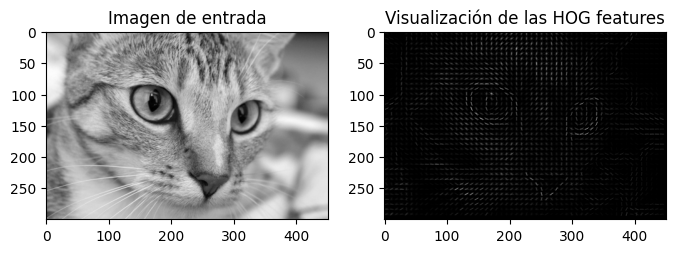

In [6]:
# Visualización
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(chelsea_gray, cmap='gray')
ax[0].set_title('Imagen de entrada')

ax[1].imshow(hog_vis, cmap='gray')
ax[1].set_title('Visualización de las HOG features');

### Explicación

*Las* características HOG (Histogram of Oriented Gradients) son utilizadas principalmente en computer vision y en procesamiento de imágenes para la detección de objetos.

1. **Gradiente de la Imagen**:
   
   El primer paso para calcular las características HOG es determinar los gradientes en $x$ e $y$ para la imagen.
   
   **Ejemplo de cálculo**
   
   Imaginemos que tenemos una pequeña porción de una imagen (3x3):
   $$I = \begin{bmatrix} 10 & 20 & 30 \\ 40 & 50 & 60 \\ 70 & 80 & 90 \end{bmatrix}$$
   Para calcular el gradiente en el centro de la imagen y en la dirección $x$, $I_x$, hacemos:
   $$I_x = 60-40=20$$
   Para calcular el gradiente en el centro de la imagen y en la dirección $y$, $I_y$, hacemos:
   $$I_y = 20-80=-60$$
   
   Este cálculo se realiza para cada posición de la imagen (ajustando los bordes según sea necesario, padding) para obtener dos imágenes completas: una para $I_x$ y otra para $I_y$, que representan los gradientes en las direcciones $x$ e $y$, respectivamente.

   **Ejemplo usando convolución con un núcleo (filtro)**.
   
   El cálculo de gradientes en imágenes se realiza aplicando convolución con **filtros derivados discretos**, típicamente de tamaño $3 \times 3$.
   
   Una forma estándar de obtener los gradientes horizontales y verticales es mediante convolución con los siguientes núcleos:
   
   **Filtro Sobel** (más robusto a ruido que la diferencia simple):
   $$
   G_x = \begin{bmatrix}
   -1 & 0 & 1 \\
   -2 & 0 & 2 \\
   -1 & 0 & 1
   \end{bmatrix}, \quad
   G_y = \begin{bmatrix}
   -1 & -2 & -1 \\
   0 &  0 &  0 \\
   1 &  2 &  1
   \end{bmatrix}
   $$

2. **Magnitud y Dirección del Gradiente**:

   Una vez que tenemos los gradientes en $x$ e $y$, podemos calcular la magnitud y la dirección del gradiente en cada píxel:

   $$\text{Magnitud} = \sqrt{I_x^2 + I_y^2}\quad \text{Dirección} = \arctan(I_y, I_x)$$

   Aquí, $\arctan$ devuelve la dirección en grados entre $[0, 180]$.

3. **Creación de Celdas y Binning de Gradients**:

   Se divide la imagen en pequeñas celdas (por ejemplo, 8x8 píxeles). Para cada celda, se crea un histograma de gradientes orientados. Esto se hace dividiendo el rango de direcciones de los gradientes, 0 a 180 grados, en "bins". Por cada píxel en la celda, se añade la magnitud de su gradiente al bin correspondiente a su dirección.

4. **Normalización**:

   Las celdas se agrupan en bloques (por ejemplo, 2x2 celdas). Se normaliza el histograma de cada bloque para reducir el efecto de cambios de iluminación. Una técnica común es usar la normalización L2:

   $$h_{\text{normalizado}} = \frac{h}{\sqrt{\|h\|_2^2 + \epsilon^2}}$$

   Donde $h$ es el histograma del bloque y $\epsilon$ es una pequeña constante para evitar la división por cero.

5. **Concatenación**:

   Finalmente, los histogramas normalizados de todos los bloques se concatenan para formar el descriptor HOG de la imagen.

La función `skimage.feature.hog` es una implementación de las características HOG en la biblioteca `skimage`:

1. **image**:
   La imagen de entrada sobre la que se calcularán las características HOG.

2. **orientations** (default=9):
   Número de bins de orientación. Se refiere al número de divisiones en el histograma de gradientes orientados. Por defecto, se dividen los 180 grados en 9 bins, resultando en bins de 20 grados cada uno.

3. **pixels_per_cell** (default=(8, 8)):
   Tamaño de la celda en píxeles (alto, ancho). En el contexto de la explicación previa, se mencionó la creación de celdas (por ejemplo, 8x8 píxeles) y la construcción de un histograma de gradientes orientados para cada celda.

4. **cells_per_block** (default=(3, 3)):
   Tamaño del bloque en celdas. Un bloque consiste en varias celdas y se utiliza para la normalización. En el ejemplo anterior, se mencionó que las celdas se agrupan en bloques (por ejemplo, 2x2 celdas) para la normalización. Aquí, el valor predeterminado sería un bloque de 3x3 celdas.

5. **block_norm** (default='L2-Hys'):
   Método para normalizar los histogramas de gradientes en los bloques. 'L2-Hys' es la normalización L2 seguida de un recorte (limitando valores máximos) y luego una nueva normalización L2. Esta técnica es común en el cálculo de características HOG y ayuda a mejorar el rendimiento del descriptor.

6. **visualize** (default=False):
   Si es True, también devuelve una imagen que visualiza las características HOG. Útil para entender y visualizar lo que está capturando el descriptor HOG de una imagen en particular.

7. **transform_sqrt** (default=False):
   Si es True, aplica una compresión de rango de valores mediante la raíz cuadrada antes del cálculo de gradientes. Esto puede ayudar a reducir el efecto de sombras o iluminación fuerte en la imagen.

8. **feature_vector** (default=True):
   Si es True, devuelve las características como un vector unidimensional. De lo contrario, las características se devuelven en la estructura de celdas/bloques original.

9. **channel_axis** (opcional):
   Especifica el eje de color en el caso de una imagen multicanal (por ejemplo, RGB). Las características HOG se calcularán por separado para cada canal y luego se concatenarán.

El `output` es un array de dimensiones

**(n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient)**

o un vector de dimensión el producto de dichas dimensiones.

### Explicación detallada de la normalización

La normalización se utiliza para reducir el impacto de las variaciones en la iluminación y el contraste en las imágenes.

La normalización suele llevarse a cabo en bloques, que son grupos de celdas. Por ejemplo, si tenemos celdas de $8 \times 8$ píxeles y definimos bloques de $2 \times 2$ celdas, tendríamos bloques de $16 \times 16$ píxeles.

**Proceso de Normalización:**

1. Calcular el histograma de gradientes orientados para cada celda en el bloque.
2. Concatenar los histogramas de todas las celdas en el bloque para formar un vector.
3. Normalizar este vector.

Uno de los métodos más comunes para normalizar es la normalización L2. Si tenemos un vector $v$, la norma L2 se calcula como:

$$\|v\|_2 = \sqrt{v_1^2 + v_2^2 + \ldots + v_n^2}$$

Y el vector normalizado $v'$ se obtiene dividiendo cada componente del vector $v$ por $\|v\|_2$.

**Ejemplo Numérico:**

Supongamos que tenemos un bloque de $2 \times 2$ celdas y cada celda tiene un histograma de gradientes orientados con 2 bins.

Histogramas de las celdas:

$$Celda_1 = [2, 3]$$
$$Celda_2 = [1, 4]$$
$$Celda_3 = [3, 1]$$
$$Celda_4 = [2, 2]$$

Concatenamos estos histogramas para formar un vector para el bloque:

$$v = [2, 3, 1, 4, 3, 1, 2, 2]$$

Calculamos la norma L2 de $v$:

$$\|v\|_2 = \sqrt{2^2 + 3^2 + 1^2 + 4^2 + 3^2 + 1^2 + 2^2 + 2^2}$$
$$\|v\|_2 = \sqrt{4 + 9 + 1 + 16 + 9 + 1 + 4 + 4}$$
$$\|v\|_2 = \sqrt{48}$$
$$\|v\|_2 = 6.93$$

Finalmente, normalizamos $v$:

$$v' = \frac{v}{\|v\|_2} = \left[\frac{2}{6.93}, \frac{3}{6.93}, \ldots\right]$$

El vector $v'$ es el vector de características HOG normalizado para ese bloque.

### Explicación de la visualización

La visualización de las características HOG es útil para comprender cómo estas características representan la estructura y orientación de los bordes en una imagen. La visualización HOG se basa en los histogramas de gradientes orientados que se calculan para cada celda en la imagen.

Para visualizar las características HOG:

1. **Cada celda se representa con un histograma**:
    En la mayoría de las implementaciones, este histograma tiene un número predefinido de "bins" que representan rangos de orientaciones. Por ejemplo, si usamos 9 bins, cada bin cubre un rango de 20° (es decir, 0-20°, 20-40°, etc., hasta 180°).

2. **Cada bin del histograma se representa mediante una línea (o flecha) cuya orientación corresponde al rango  del bin (u ortogonal al rango del bin)**:
    La longitud (o magnitud) de esta línea es proporcional a la cantidad acumulada en ese bin del histograma. Una mayor magnitud implica que hay muchos gradientes (o bordes) en la imagen que tienen esa orientación particular en la celda actual.
  
3. **Las líneas se dibujan en el centro de la celda correspondiente**:
    De esta manera, obtenemos una representación visual donde las zonas con líneas más largas y densas corresponden a áreas de la imagen con estructuras (o bordes) más definidas.

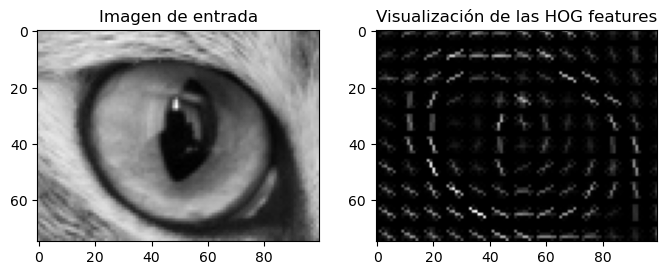

In [ ]:
# Visualización (zoom)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(chelsea_gray[75:150,120:220], cmap='gray')
ax[0].set_title('Imagen de entrada')

ax[1].imshow(hog_vis[75:150,120:220], cmap='gray')
ax[1].set_title('Visualización de las HOG features');

La visualización HOG y cómo se relaciona con la imagen original.

1. **Imagen de Entrada**:
    La imagen de la izquierda muestra un ojo en escala de grises. Se pueden identificar estructuras visibles, como el borde del párpado superior e inferior, el iris y la pupila. Estas estructuras tienen bordes bien definidos que serán capturados por las características HOG.

2. **Visualización de las HOG features**:
    La imagen de la derecha es una representación visual de las características HOG calculadas para la imagen de entrada.
    
    Cada pequeña línea o flecha representa la orientación (u ortogonal) y magnitud del gradiente en una celda particular. Las áreas con estructuras más definidas en la imagen original, como el borde del párpado y el contorno del iris, muestran líneas más prominentes en la visualización HOG. Estas líneas indican la dirección del gradiente y su longitud indica la fuerza del borde o gradiente en esa celda. Las zonas más oscuras o uniformes de la imagen original (como la esclerótica del ojo) tienen menos flechas prominentes en la visualización HOG porque hay menos variación y, por lo tanto, gradientes más débiles.
    
    La disposición circular del iris y la pupila en la imagen original se refleja en la visualización HOG como un patrón de líneas que sugiere un cambio circular en las orientaciones.